# Car Price Predictor
This project takes data from multiple CSV files, taken from ~100,000 UK used car listings, and produces a linear regression model to predict a cars price from its features, such as make, model, mileage, etc.

## Import Local Dependencies
This project relys upon
* Pandas (Data Processing)
* Matplotlib (Visualisation)
* Numpy (Calculations)
* Scikit-learn (Machine Learning)

In [1]:
# Pandas
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

## Import Data
The data for this project is stored in multiple .csv files, in the data directory.

This block loads that data into one Pandas dataframe, while removing redundant data.

In [2]:
brands = ["audi", "bmw", "mercedes", "ford", "hyundi", "skoda", "toyota", "vauxhall", "vw"]

df = pd.DataFrame(columns=[
    "brand",
    "model", 
    "year", 
    "price", 
    "transmission", 
    "mileage", 
    "fuelType", 
    "engineSize", 
    "tax", 
    "mpg"
])

for brand in brands:
    loaded = pd.read_csv(f"./data/{brand}.csv")
    loaded["brand"] = str(brand)
    loaded["model"] = loaded["model"].str.lower()
    
    df = pd.concat([df, loaded])
    
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
df

brand model  year  price transmission mileage fuelType  engineSize  tax  \
0      audi    a1  2017  12500       Manual   15735   Petrol         1.4  150   
1      audi    a6  2016  16500    Automatic   36203   Diesel         2.0   20   
2      audi    a1  2016  11000       Manual   29946   Petrol         1.4   30   
3      audi    a4  2017  16800    Automatic   25952   Diesel         2.0  145   
4      audi    a3  2019  17300       Manual    1998   Petrol         1.0  145   
...     ...   ...   ...    ...          ...     ...      ...         ...  ...   
15152    vw   eos  2012   5990       Manual   74000   Diesel         2.0  125   
15153    vw   fox  2008   1799       Manual   88102   Petrol         1.2  145   
15154    vw   fox  2009   1590       Manual   70000   Petrol         1.4  200   
15155    vw   fox  2006   1250       Manual   82704   Petrol         1.2  150   
15156    vw   fox  2007   2295       Manual   74000   Petrol         1.2  145   

        mpg  
0      55.4  
1      64.2  
2      55.4  
3      67.3  
4      49.6  
...     ...  
15152  58.9  
15153  46.3  
15154  42.0  
15155  46.3  
15156  46.3  

[99187 rows x 10 columns]

## Processing
One issue is that many columns that are numeric are being represented as strings, and so can't be manipulated or calculated with. Thus, I need to cast them to numeric values, as well as doing some other processing.

In [3]:
df["year"] = df["year"].astype(int)
df["price"] = df["price"].astype(float)
df["mileage"] = df["mileage"].astype(int)
df["tax"] = df["tax"].astype(float)

# There's a datapoint at 2060 for some reason

i = df[ df["year"] == 2060 ].index
df.drop(i, inplace=True)

# Using One-Hot Encoding for the transmission and fuel types, for ML later

Tcategories = ["Manual", "Automatic", "Semi-Auto", "Other"]
Fcategories = ["Petrol", "Diesel", "Hybrid", "Electric", "Other"]

for c in Tcategories:
    df["t_"+c.lower()] = df["transmission"] == c

for f in Fcategories:
    df["f_"+f.lower()] = df["fuelType"] == f

df.head()

brand model  year    price transmission  mileage fuelType  engineSize  \
0  audi    a1  2017  12500.0       Manual    15735   Petrol         1.4   
1  audi    a6  2016  16500.0    Automatic    36203   Diesel         2.0   
2  audi    a1  2016  11000.0       Manual    29946   Petrol         1.4   
3  audi    a4  2017  16800.0    Automatic    25952   Diesel         2.0   
4  audi    a3  2019  17300.0       Manual     1998   Petrol         1.0   

     tax   mpg  t_manual  t_automatic  t_semi-auto  t_other  f_petrol  \
0  150.0  55.4      True        False        False    False      True   
1   20.0  64.2     False         True        False    False     False   
2   30.0  55.4      True        False        False    False      True   
3  145.0  67.3     False         True        False    False     False   
4  145.0  49.6      True        False        False    False      True   

   f_diesel  f_hybrid  f_electric  f_other  
0     False     False       False    False  
1      True     False       False    False  
2     False     False       False    False  
3      True     False       False    False  
4     False     False       False    False

## Data Analysis

First, model the fluctuations in price over time for manual, semi-auto, and automatic cars

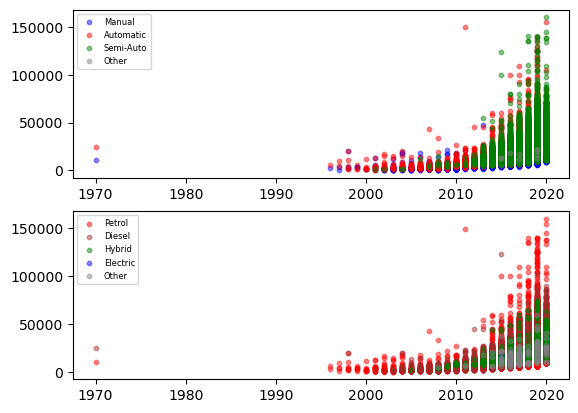

In [4]:
line_styles = {
    "Automatic": "red", 
    "Manual": "blue", 
    "Semi-Auto": "green",
    "Other": "grey",
    "Petrol": "red",
    "Diesel": "brown",
    "Electric": "blue",
    "Hybrid": "green"
}

figure, axis = plt.subplots(2, 1)


for t in Tcategories:
    xpoints = df[ df[f"t_{t.lower()}"] == True ]["year"]
    ypoints = df[ df[f"t_{t.lower()}"] == True ]["price"]
    axis[0].scatter(xpoints, ypoints, color = line_styles[t], s=10, alpha=0.45, label=t)
    axis[0].legend(loc="upper left", prop={"size": 6})

for t in Fcategories:
    xpoints = df[ df[f"f_{t.lower()}"] == True ]["year"]
    ypoints = df[ df[f"f_{t.lower()}"] == True ]["price"]
    axis[1].scatter(xpoints, ypoints, color = line_styles[t], s=10, alpha=0.45, label=t)
    axis[1].legend(loc="upper left", prop={"size": 6})
    
    
       
plt.show()

Newer cars sell for a far greater price, but it would seem Semi-Auto cars (plotted in green) lose their value faster, whereas automatics have kept their value over a longer value.

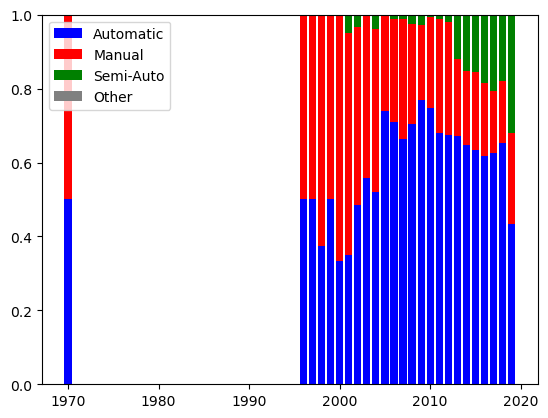

In [5]:
# Plot the proportion of each type sold over time

X = np.array( [i for i in range( df["year"].min(), df["year"].max() ) ] )

colours = {
    "Automatic": "red",
    "Manual": "blue",
    "Semi-Auto": "green",
    "Other": "grey"
}

for x in X:
    preportions = []
    year_data = df[ df["year"] == x ]
    if not year_data.empty:
        for t in df["transmission"].unique():
            preportions.append(len(year_data[ year_data["transmission"] == t ]) / len(year_data))
            plt.bar(x, preportions[-1], bottom=sum(preportions) - preportions[-1], color=colours[t] )
    

plt.legend(["Automatic", "Manual", "Semi-Auto", "Other"])
plt.show()

This bar chart shows how many, as a proportion, of each transmission type are being sold from each year.

This chart shows that, of cars being sold, a majority of automatics are from ~ 2005 - 2018, whereas manuals are more prevalently from earlier (~1998). 

Semi-autos being sold only becomes more prevalent later on in the data, showing that this design is only starting to have an impact in the used car market.